In [22]:
import cv2
import time
import numpy
import torch
import torchvision
import subprocess as sp
import tempfile
import imageio
import matplotlib.pyplot as plt

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
 
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
 
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
 
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
 
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
 
      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);
 
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  print('Saved to {}'.format(filename))
  return filename

def download(url):
  fd, tmppath = tempfile.mkstemp()
  sp.run(f'wget {url} -O {tmppath}', shell=True, check=True)
  return tmppath

In [5]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()
model.float()

def store_output(self, input, output):
  self._output = output
  return output

for c in model.backbone.body.children():
  c.register_forward_hook(store_output)

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
COLORS = (numpy.random.rand(len(COCO_INSTANCE_CATEGORY_NAMES),3) * 255)

In [6]:
def get_prediction(img_path, threshold):
  im = imageio.imread(img_path)
  input = torch.from_numpy(im/im.max()).permute([2,0,1]).float()
  if torch.cuda.device_count() > 0:
    input = input.cuda()
    model.cuda()

  pred = model([input])

  pred_cls = pred[0]['labels'].cpu().numpy() # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].cpu().detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].cpu().detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_cls = pred_cls[:pred_t+1]
  return pred_boxes, pred_cls


In [20]:
def object_detection_api(img_path, threshold=0.7, rect_th=2, text_size=1, text_th=2):
  if img_path[:4] == 'http' :
    img_path = download(img_path)

  t0 = time.time()
  boxes, cls_ids = get_prediction(img_path, threshold) # Get predictions
  t_pred = time.time() - t0
  print(f'prediction effectuée en {t_pred:.1f} sec')
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  
  cls_names = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in cls_ids] # Get the Prediction Score
  # boxes = numpy.round(boxes).astype(numpy.int)
  for i in range(len(boxes)):
    color = COLORS[cls_ids[i]]
    cv2.rectangle(img, boxes[i][0], boxes[i][1], color=color, thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,cls_names[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, color=color, thickness=text_th) # Write the prediction class
  plt.figure(figsize=(20,30)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()


In [ ]:
object_detection_api('https://home.bt.com/images/google-street-view-of-trafalgar-square-136400836729002601-151002115607.jpg')

object_detection_api('https://www.publichealth.columbia.edu/sites/default/files/styles/hero_1500x632/public/jpg/streetview-oncomingtruck-1500x632.jpg?itok=IXmJ5akJ')

object_detection_api('https://www.visitsingapore.com/festivals-events-singapore/annual-highlights/international-champions-cup/_jcr_content/par-carousel/carousel_detailpage/carousel/item_1.thumbnail.carousel-img.740.416.jpg')

In [ ]:
for name, mod in model.backbone.body.items():
  plt.figure(figsize=(25,10))
  print(name)  
  maps = mod._output[0].cpu().detach()

  variances = maps.reshape(maps.shape[0], -1).std(axis=1)
  indices = variances.argsort(descending = True)
  maps = maps[indices[:20]]
  for k, map in enumerate(maps):
    plt.subplot(4, 5, k+1)
    plt.imshow(map, cmap='jet')
  plt.show()

In [ ]:
object_detection_api(take_photo())

<IPython.core.display.Javascript object>

Saved to photo.jpg
prediction effectuée en 0.5 sec


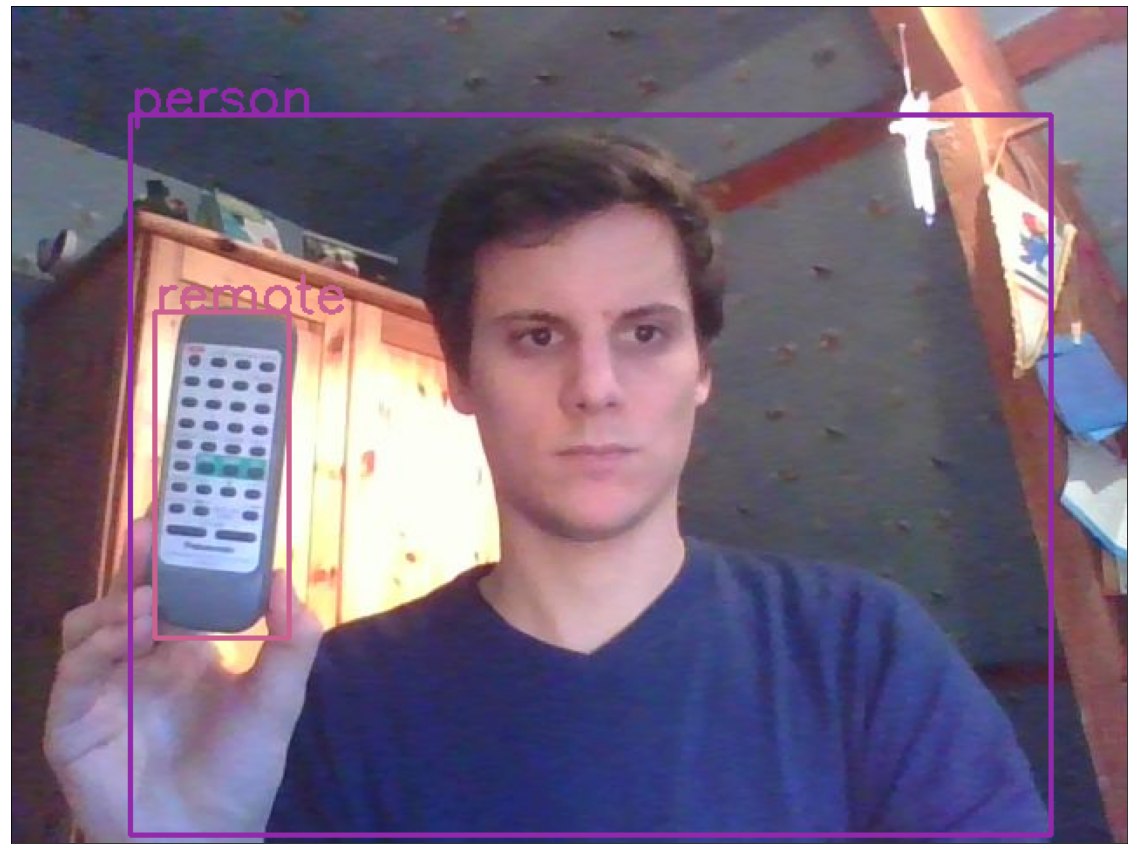

In [40]:
object_detection_api(take_photo())

<IPython.core.display.Javascript object>

Saved to photo.jpg
prediction effectuée en 0.5 sec


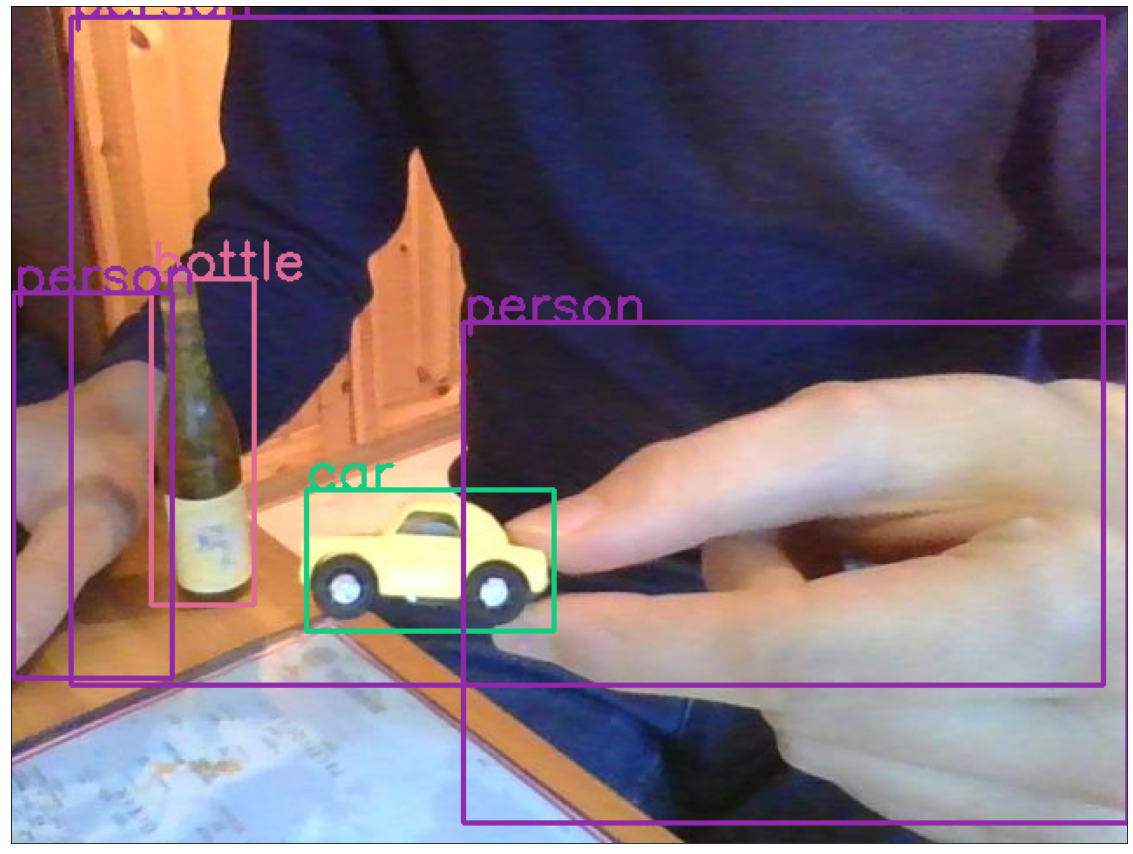

In [38]:
object_detection_api(take_photo())